<a href="https://colab.research.google.com/github/Shiyasalloor/Deep_Learning_Lab/blob/main/PPCA_for_Image_Compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist.data.astype(np.float32) / 255.0
X = StandardScaler().fit_transform(X)

X_train = X[:5000]


In [3]:
k = 50  # latent dimensions
pca = PCA(n_components=k)
Z_pca = pca.fit_transform(X_train)
X_recon_pca = pca.inverse_transform(Z_pca)


In [4]:
class PPCA:
    def __init__(self, n_components, tol=1e-4, max_iter=100):
        self.n_components = n_components
        self.tol = tol
        self.max_iter = max_iter

    def fit(self, X):
        N, D = X.shape
        k = self.n_components

        # Initialize parameters
        self.mean_ = np.mean(X, axis=0)
        Xc = X - self.mean_
        C = np.cov(Xc.T)

        # Random init
        W = np.random.randn(D, k)
        sigma2 = np.random.rand()

        for i in range(self.max_iter):
            M = W.T @ W + sigma2 * np.eye(k)
            M_inv = np.linalg.inv(M)

            # E-step
            Ez = Xc @ W @ M_inv
            Ezz = sigma2 * M_inv + Ez[:,:,None] @ Ez[:,None,:]

            # M-step
            W_new = (Xc.T @ Ez) @ np.linalg.inv(np.sum(Ezz, axis=0))
            sigma2_new = (np.sum(Xc**2) - 2*np.trace((Xc.T @ Ez) @ W_new.T) + np.trace(np.sum(Ezz, axis=0) @ (W_new.T @ W_new))) / (N*D)

            # Convergence check
            if np.linalg.norm(W_new - W) < self.tol:
                break
            W, sigma2 = W_new, sigma2_new

        self.W, self.sigma2 = W, sigma2
        return self

    def transform(self, X):
        Xc = X - self.mean_
        M = self.W.T @ self.W + self.sigma2 * np.eye(self.n_components)
        M_inv = np.linalg.inv(M)
        return Xc @ self.W @ M_inv

    def inverse_transform(self, Z):
        return Z @ self.W.T + self.mean_

In [5]:
ppca = PPCA(n_components=k, max_iter=50)
ppca.fit(X_train)
Z_ppca = ppca.transform(X_train)
X_recon_ppca = ppca.inverse_transform(Z_ppca)

In [6]:
mse_pca = mean_squared_error(X_train, X_recon_pca)
mse_ppca = mean_squared_error(X_train, X_recon_ppca)

print(f"PCA MSE: {mse_pca:.4f}")
print(f"PPCA MSE: {mse_ppca:.4f}")

PCA MSE: 0.3309
PPCA MSE: 0.3315


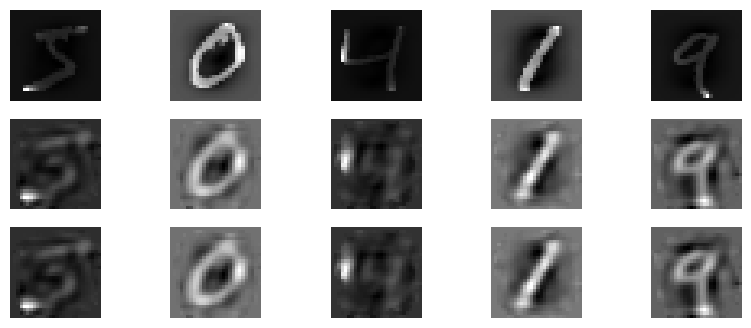

In [7]:
def show_images(original, pca_recon, ppca_recon, n=5):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        # Original
        plt.subplot(3, n, i+1)
        plt.imshow(original[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
        if i == 0: plt.ylabel("Original")

        # PCA
        plt.subplot(3, n, n+i+1)
        plt.imshow(pca_recon[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
        if i == 0: plt.ylabel("PCA")

        # PPCA
        plt.subplot(3, n, 2*n+i+1)
        plt.imshow(ppca_recon[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
        if i == 0: plt.ylabel("PPCA")

    plt.show()

show_images(X_train, X_recon_pca, X_recon_ppca, n=5)